In [1]:
from __future__ import absolute_import, division, print_function

# Run Kernel Density Estimate on image distribution

In [212]:
import os
import json
import pandas as pd
import glob
import numpy as np
import shapefile as sf
from pyproj import Proj, transform
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import copy
from sklearn.neighbors.kde import KernelDensity
from sklearn.datasets.species_distributions import construct_grids
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.path as mplPath

%matplotlib inline


In [213]:
# import dataframe
df = pd.read_pickle(os.path.join('..','data','dog.df'))

In [214]:
# Get CA coordinates
infile = os.path.join('..','data','ca_shape.csv')
ca_shape = pd.read_csv(infile)
ca_shape.head()

,longitude,latitude
0,-124.408601,40.443201
1,-124.396642,40.462119
2,-124.395598,40.464590
3,-124.388450,40.481511
4,-124.384940,40.489820


In [257]:


# yin = np.array((df['longitude'][df['longitude'] != 0.0].tolist()))
# xin = np.array((df['latitude'][df['latitude'] != 0.0].tolist()))

limit_lng = [-122.5,-122.0]
limit_lat = [37.1,37.7]

limit_lng = [-122.4,-122]
limit_lat = [37.4,37.7]

if len(limit_lng) != 0 and len(limit_lat) != 0:
    yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                    (df['longitude'] < limit_lng[1]) & 
                                    (df['latitude'] > limit_lat[0]) & 
                                    (df['latitude'] < limit_lat[1])].tolist()))

    xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                   (df['longitude'] < limit_lng[1]) & 
                                   (df['latitude'] > limit_lat[0]) & 
                                   (df['latitude'] < limit_lat[1])].tolist()))
else:
    yin = np.array((df['longitude'][df['longitude'] != 0.0].tolist()))
    xin = np.array((df['latitude'][df['latitude'] != 0.0].tolist()))
    

print(len(xin))
print(len(yin))

lng_max = max(yin)
lng_min = min(yin)
lat_max = max(xin)
lat_min = min(xin)

xin = xin[::10]
yin = yin[::10]


print(lng_min,lng_max,lat_min,lat_max)

# Set up the data grid for the contour plot
xgrid = np.linspace(lng_min,lng_max,100)
ygrid = np.linspace(lat_min,lat_max,100)
X, Y = np.meshgrid(xgrid, ygrid)

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy *= np.pi / 180.

Xtrain = np.vstack([xin,yin]).T

# ytrain = np.array([d.decode('ascii').startswith('micro')
#                   for d in data['train']['species']], dtype='int')

Xtrain *= np.pi / 180.  # Convert lat/long to radians

# kde = KernelDensity(bandwidth=0.0002,metric='haversine',
#                     kernel='gaussian', algorithm='ball_tree')

kde = KernelDensity(bandwidth=0.0001,)


kde.fit(Xtrain)


2941
2941
-122.399 -122.003 37.4002 37.6992


KernelDensity(algorithm='auto', atol=0, bandwidth=0.0001, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

## Decide which points of the grid fall into the ocean

In [258]:
# # Calculate paths number 
# x_coords = ca_shape['longitude'].tolist()
# y_coords = ca_shape['latitude'].tolist()

# bbPath = mplPath.Path(np.transpose(np.array((x_coords,y_coords))),closed=True)
# land_mask = np.vstack([Y.ravel(), X.ravel()]).T
# land_mask = (land_mask < -9999).ravel()
# print(land_mask)
# for xidx,xcoord in enumerate(xgrid):
#     for yidx,ycoord in enumerate(ygrid):
#         test = bbPath.contains_point((xcoord, ycoord))
#         if test:
#             land_mask[xidx:yidx] = True


In [259]:
# print(land_mask)

In [260]:
# print(xy)

In [261]:
# print(Xtrain)

In [262]:
Z = -9999 + np.zeros(land_mask.shape[0])
Z = np.exp(kde.score_samples(xy))
print(Z)


[  1.28219925e-57   5.53305654e-57   1.46657688e-56 ...,   6.95057935e-02
   4.21616858e-03   1.57089190e-04]


In [263]:
Z = Z.reshape(X.shape)

In [210]:
# print(len(Z))
# print(np.min(Z),np.max(Z))
# print(Z)


100
0.0 649062.19058
[[  0.00000000e+000   0.00000000e+000   0.00000000e+000 ...,
    2.80469805e-153   4.47601231e-170   4.40748945e-188]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000 ...,
    1.95115276e-142   3.14609269e-159   3.13234001e-177]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000 ...,
    5.78512868e-133   9.42474821e-150   9.48781111e-168]
 ..., 
 [  7.07096998e-006   4.36709218e-003   1.90904941e-001 ...,
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  5.49171479e-010   3.38551198e-007   1.47836145e-005 ...,
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  1.81779483e-015   1.11857221e-012   4.87923373e-011 ...,
    0.00000000e+000   0.00000000e+000   0.00000000e+000]]


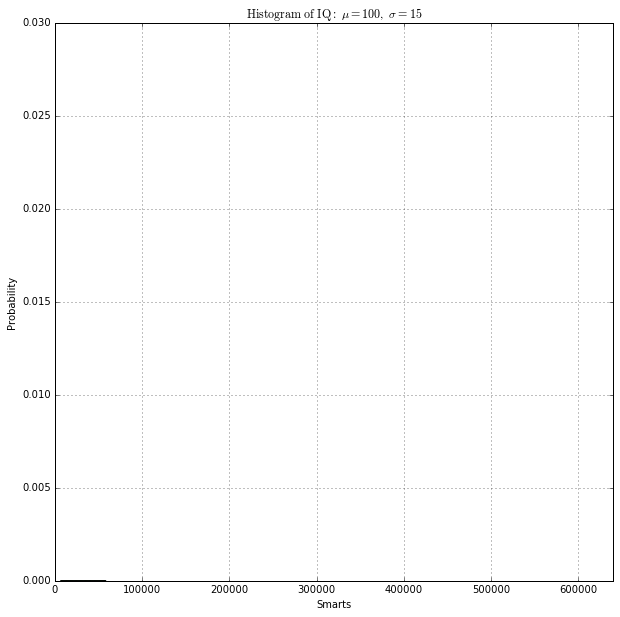

In [204]:
# import matplotlib.mlab as mlab
# plt.figure(figsize=(10,10))
# # the histogram of the data
# n, bins, patches = plt.hist(Z, 10, normed=1, facecolor='green', alpha=0.75)
# # Styling
# plt.xlabel('Smarts')
# plt.ylabel('Probability')
# plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
# plt.axis([0, 640000, 0, 0.03])
# plt.grid(True)

# plt.show()


In [205]:
print(bins)

[      0.           64906.21905799  129812.43811597  194718.65717396
  259624.87623194  324531.09528993  389437.31434792  454343.5334059
  519249.75246389  584155.97152187  649062.19057986]


[    0.            23.64545986    47.29091972    70.93637958    94.58183943
   118.22729929   141.87275915   165.51821901   189.16367887   212.80913873
   236.45459859   260.10005844   283.7455183    307.39097816   331.03643802
   354.68189788   378.32735774   401.9728176    425.61827745   449.26373731
   472.90919717   496.55465703   520.20011689   543.84557675   567.49103661
   591.13649646   614.78195632   638.42741618   662.07287604   685.7183359
   709.36379576   733.00925562   756.65471547   780.30017533   803.94563519
   827.59109505   851.23655491   874.88201477   898.52747463   922.17293448
   945.81839434   969.4638542    993.10931406  1016.75477392  1040.40023378
  1064.04569364  1087.69115349  1111.33661335  1134.98207321  1158.62753307]


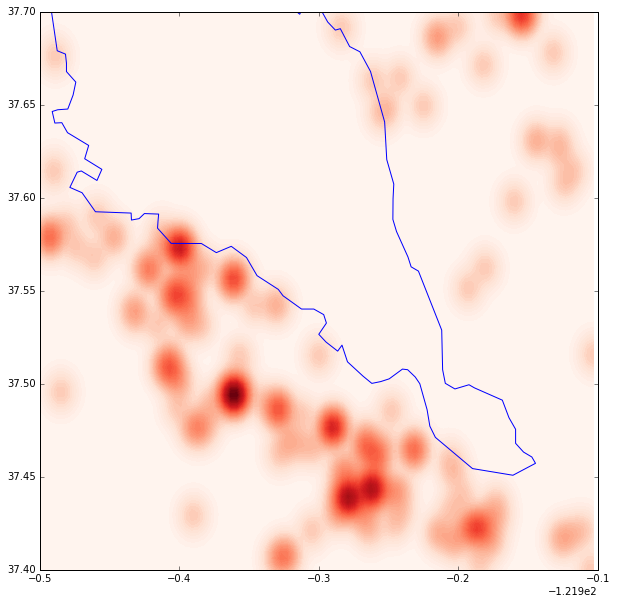

In [264]:
plt.figure(figsize=(10,10))

# plot CA outline
x_coords = ca_shape['longitude'].tolist()
y_coords = ca_shape['latitude'].tolist()
# x_coords = [x*np.pi / 180. for x in x_coords]
# y_coords = [x*np.pi / 180. for x in y_coords]
plt.plot(x_coords,y_coords)

#  plot contours of the density
levels = np.linspace(0, np.log10(Z.max()), 50)
levels = np.linspace(0, np.sqrt(Z.max()), 50)
print(levels)
# print(levels)
# print(Z)
plt.contourf(X, Y, np.sqrt(Z), levels=levels, cmap=plt.cm.Reds)
if len(limit_lng) != 0 and len(limit_lat) != 0:
    plt.xlim(limit_lng[0],limit_lng[1])
    plt.ylim(limit_lat[0],limit_lat[1]) 
else:
    plt.xlim(-123,-121.5)
    plt.ylim(36.8,38.5) 
    

plt.show()


# Find local maxima in KDE map

In [265]:
from sklearn.cluster import MeanShift, estimate_bandwidth

ms = MeanShift(X)
ms.fit(X)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()